a:\Programs\anaconda3\envs\ai\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
a:\Programs\anaconda3\envs\ai\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\Kontor\AppData\Local\Temp\ipykernel_11932\2989236445.py:38: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  segments = slic(image_numpy, n_segments=100, compactness=10)


  0%|          | 0/500 [00:00<?, ?it/s]

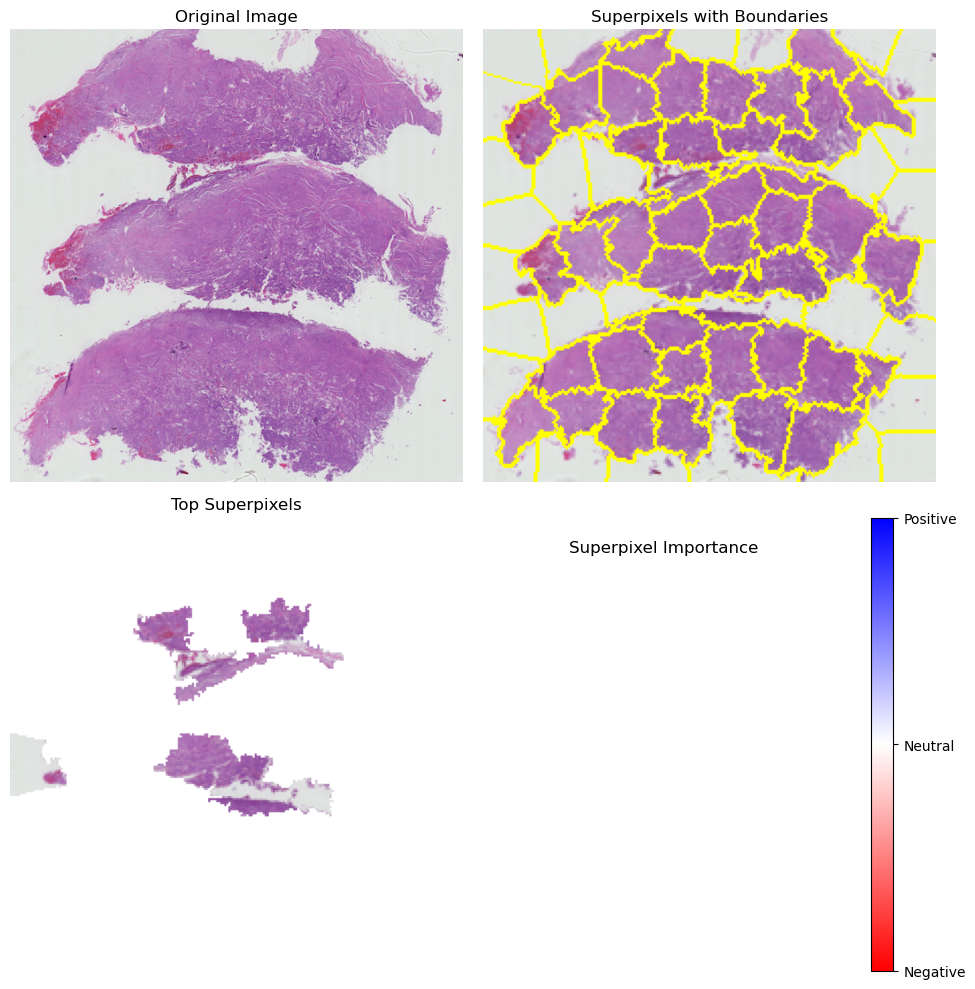

In [4]:
import torch
from torchvision.models import vgg16
from torchvision.transforms import ToTensor, Resize
from lime import lime_image
from skimage.segmentation import slic, mark_boundaries
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Load the pre-trained VGG16 model
model = vgg16(pretrained=False)
model.eval()

# Define the LimeImageExplainer
explainer = lime_image.LimeImageExplainer()

# Define the custom transform class
class CustomTransform:
    def __init__(self, size):
        self.size = size

    def __call__(self, image):
        image = image.resize(self.size)
        image = ToTensor()(image)
        return image

# Define the path to your image
image_path = 'histo_images/test.png'

# Load the image and apply the transformations
image = Image.open(image_path)
transform = CustomTransform((224, 224))
image_tensor = transform(image)
image_numpy = image_tensor.numpy().transpose(1, 2, 0)

# Generate superpixels using SLIC
segments = slic(image_numpy, n_segments=100, compactness=10)

# Define the prediction function for the VGG16 model
def batch_predict(images):
    images = torch.tensor(images).permute(0, 3, 1, 2)
    outputs = model(images)
    return outputs.detach().numpy()

# Generate explanations using LIME
explanation = explainer.explain_instance(
    image_numpy,
    batch_predict,
    top_labels=1,
    num_samples=500,
    segmentation_fn=lambda x: segments,
    random_seed=42
)

# Retrieve the superpixel weights for the predicted class label
predicted_label = np.argmax(batch_predict(np.expand_dims(image_numpy, 0)))
superpixel_weights = explanation.local_exp[predicted_label]

# Create a mask to visualize superpixels with yellow boundaries
image_boundaries = mark_boundaries(image_numpy, segments, color=(1, 1, 0))

# Create a colormap for visualizing superpixel importance
cmap = LinearSegmentedColormap.from_list('lime_cmap', ['red', 'white', 'blue'])

# Create a weighted mask based on superpixel importance
weighted_mask = np.zeros_like(segments, dtype=np.float32)
for idx, weight in superpixel_weights:
    weighted_mask[segments == idx] = weight

# Plot the original image
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].imshow(image)
ax[0, 0].axis('off')
ax[0, 0].set_title('Original Image')

# Plot the superpixels with yellow boundaries
ax[0, 1].imshow(image_boundaries)
ax[0, 1].axis('off')
ax[0, 1].set_title('Superpixels with Boundaries')

# Plot the image with the most important superpixels
top_superpixels = [idx for idx, _ in superpixel_weights[:5]]  # Change the number to show more or fewer superpixels
top_superpixels_mask = np.isin(segments, top_superpixels)
top_superpixels_image = np.where(top_superpixels_mask[..., None], image_numpy, 1.0)
ax[1, 0].imshow(top_superpixels_image)
ax[1, 0].axis('off')
ax[1, 0].set_title('Top Superpixels')

# Plot the image with superpixel importance and colorbar
im = ax[1, 1].imshow(weighted_mask, cmap=cmap, vmin=-1.0, vmax=1.0)
ax[1, 1].axis('off')
ax[1, 1].set_title('Superpixel Importance')

# Add colorbar
cbar = fig.colorbar(im, ax=ax[1, 1], ticks=[-1, 0, 1])
cbar.ax.set_yticklabels(['Negative', 'Neutral', 'Positive'])

plt.tight_layout()
plt.show()
